In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy import signal
import scipy.cluster.hierarchy as spc
from pandas import read_excel
from ipywidgets import widgets
from ipywidgets import interactive, HBox, VBox
import plotly.io as pio

In [5]:
country_list_iso = ["FRA","BEL","BGR","CYP","CZE","DEU","DNK","EST","ESP","FIN","AUT","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","POL","PRT","ROU","SWE","SVN","SVK"]

PATH_Q = "data_nico_quarterly/"
PATH_H = "data_nico_household/"
names_q = [name for name in os.listdir(PATH_Q) if ".csv" in name]
names_h = [name for name in os.listdir(PATH_H) if ".csv" in name]

In [6]:
def proc_cols(df, value_name):
    df = df.rename(columns={"Value": value_name})
    return df.drop(['INDICATOR', 'SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis=1)

def generate_df(csv_names,path):
    df = None
    str_end = len(".csv")
    for name in csv_names:
        if df is None:
            df = proc_cols(pd.read_csv(path+name),name[:-str_end])
        else:
            new_df = proc_cols(pd.read_csv(path+name),name[:-str_end])
            df = pd.merge(df, new_df,  how='outer', left_on=['LOCATION','TIME'], right_on = ['LOCATION','TIME'])
    return df

def df_date_format(df):
    return df.replace({'-Q1':'-01-01','-Q2':'-04-01','-Q3':'-07-01','-Q4':'-10-01'}, regex=True)

#adds date format and only starting from 2004
def df_date_format_yearly(df):
    df = df[df["TIME"] >= 2004].copy() #copy for warning
    df["TIME"] = df["TIME"].astype(str) + "-01-01"
    return df

### quarterly unemployment and GDP growth

In [7]:
#https://data.oecd.org/gdp/gross-domestic-product-gdp.htm
#https://data.oecd.org/unemp/harmonised-unemployment-rate-hur.htm#indicator-chart
df = generate_df(names_q,PATH_Q)

In [8]:
df.head()

LOCATION     TIME  GDP_growth       HUR
0      GBR  2004-Q1    0.543784  4.700000
1      GBR  2004-Q2    0.357844  4.700000
2      GBR  2004-Q3    0.165857  4.600000
3      GBR  2004-Q4    0.329016  4.700000
4      GBR  2005-Q1    0.840414  4.633333

In [9]:
df_hur = df_date_format(df[['LOCATION','TIME','HUR']])
df_gdp = df_date_format(df[['LOCATION','TIME','GDP_growth']])

In [10]:
len(df_gdp['LOCATION'].unique())

26

In [11]:
df_hur = df_hur.pivot_table(values='HUR', index='TIME', columns='LOCATION')
df_gdp = df_gdp.pivot_table(values='GDP_growth', index='TIME', columns='LOCATION')

In [12]:
df_hur.head()

LOCATION         AUT       BEL       CZE       DEU       DNK       ESP  \
TIME                                                                     
2004-01-01  5.633333  8.533334  8.433333  10.06667  5.666667  11.20000   
2004-04-01  5.366667  7.766667  8.333333  10.30000  5.466667  11.20000   
2004-07-01  5.466667  8.866667  8.233334  10.36667  5.600000  10.96667   
2004-10-01  5.500000  8.366667  8.266666  10.60000  5.333333  10.53333   
2005-01-01  5.433333  8.466666  8.066667  10.83333  5.233333   9.90000   

LOCATION          EST       FIN  FRA       GBR  ...        LTU       LUX  \
TIME                                            ...                        
2004-01-01  10.100000  9.000000  8.8  4.700000  ...  11.400000  4.733333   
2004-04-01   9.733334  8.966666  8.8  4.700000  ...  10.900000  5.000000   
2004-07-01  10.200000  8.700000  8.8  4.600000  ...  10.766670  5.066667   
2004-10-01   9.766666  8.666667  8.9  4.700000  ...  10.500000  5.000000   
2005-01-01   9.033334  8.600000  8.7  4.633333  ...   9.533334  4.766667   

LOCATION         LVA       NLD      OECD       POL       PRT       SVK  \
TIME                                                                     
2004-01-01  11.76667  5.433333  7.030766  19.90000  7.266667  18.90000   
2004-04-01  11.43333  5.766667  6.945943  19.33333  7.666667  18.80000   
2004-07-01  11.76667  5.666667  6.889487  18.86667  8.000000  18.03333   
2004-10-01  12.00000  5.766667  6.823681  18.43333  8.166667  17.70000   
2005-01-01  11.00000  5.966667  6.710604  18.20000  8.400000  17.13333   

LOCATION         SVN       SWE  
TIME                            
2004-01-01  6.500000  7.333333  
2004-04-01  6.333333  7.366667  
2004-07-01  6.166667  7.433333  
2004-10-01  6.300000  7.366667  
2005-01-01  6.433333  7.366667  

[5 rows x 24 columns]

In [13]:
def plot_lines(df,value_smooth):
    fig = go.Figure()
    for x in df.columns:
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=df[x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df[x],value_smooth, 3), mode='lines',name=x))
    return fig

In [14]:
len(df_hur.iloc[1])

24

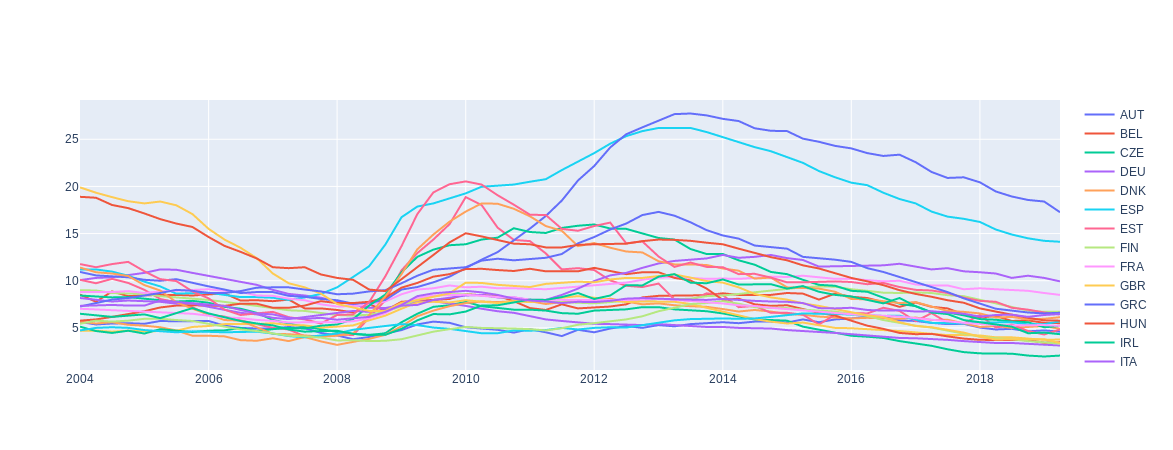

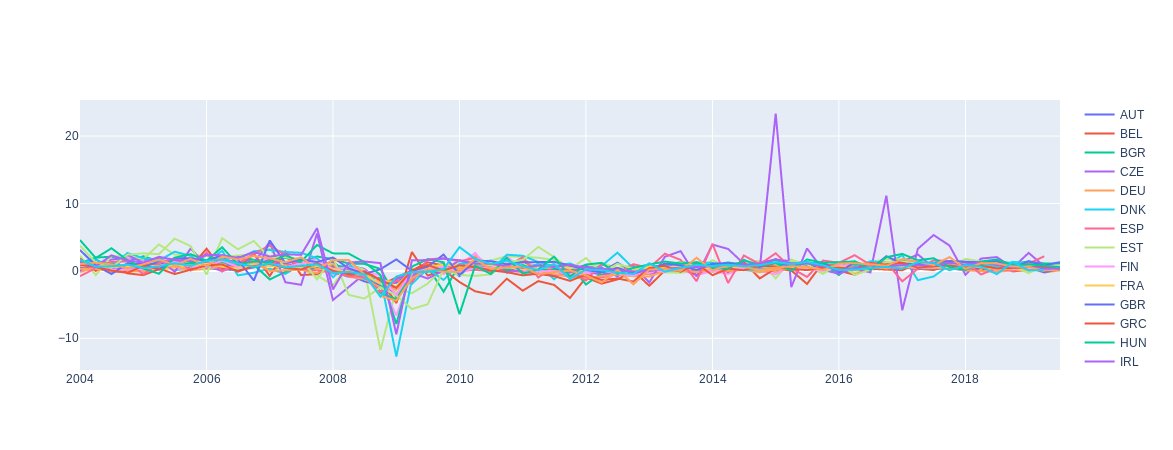

In [15]:
plot_lines(df_hur,0).show()
plot_lines(df_gdp,0).show()

In [16]:
df_corr_hur = df_hur.corr(method ='spearman')
df_corr_gdp = df_gdp.corr(method ='spearman')

In [17]:
df_corr_hur.shape

(24, 24)

In [18]:
def getIdx(corr,variableTweak):
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, variableTweak * pdist.max(), 'distance')
    return idx

def getGroup(number,idx):
    group = []
    for i in range(0,len(idx)):
        x = idx[i]
        if x == number:
            group.append(i)
    return group


def plotDifferentGroup(idx,dfPlot,indicePlot,val):
    for i in range(1,max(idx)+1):
        df1 = dfPlot[dfPlot.columns[getGroup(i,idx)]]
        plot_lines(df1,indicePlot).update_layout(title_text = 'Visualization of {} for group '.format(val)+str(i),).show()

#values to plot 4 groups
idx = getIdx(df_corr_hur,0.65)
# idx = getIdx(df_corr_gdp,0.8)

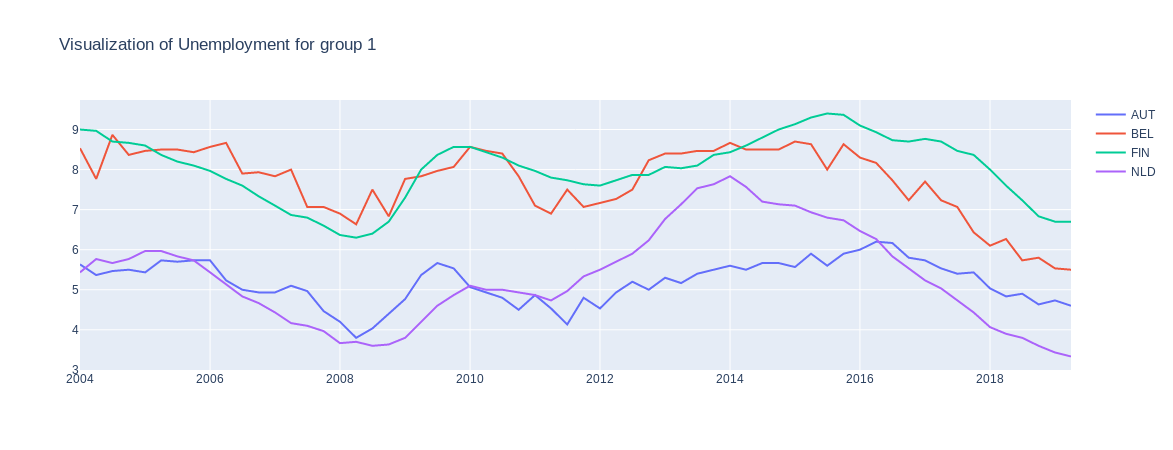

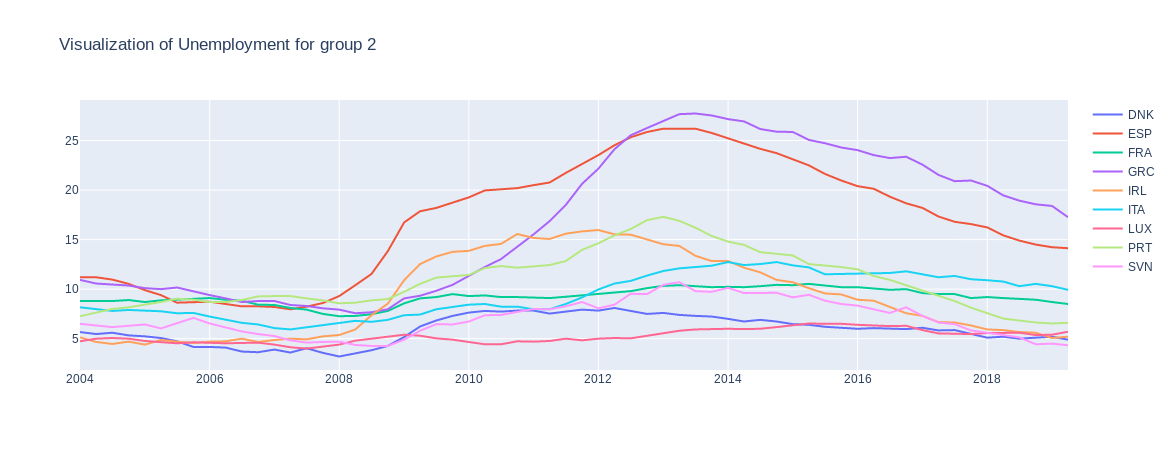

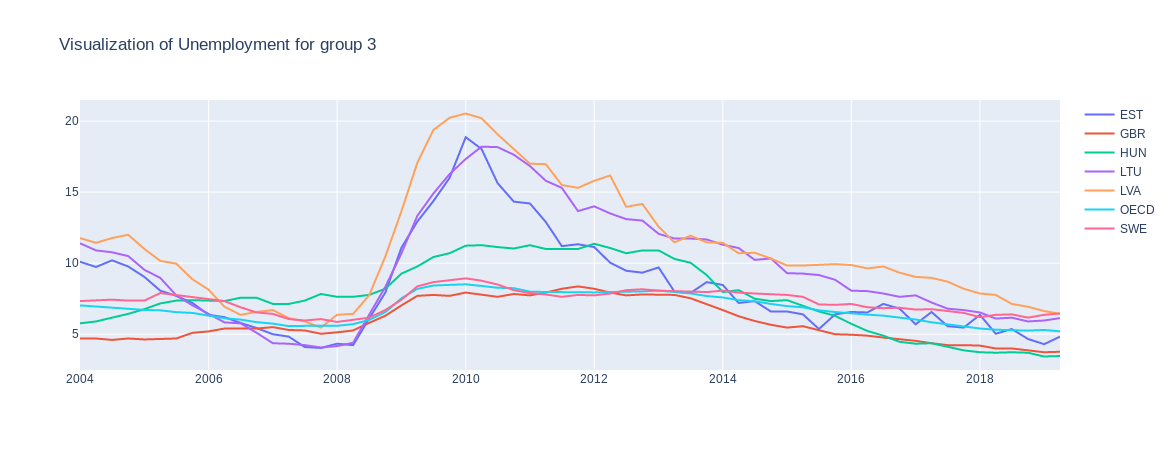

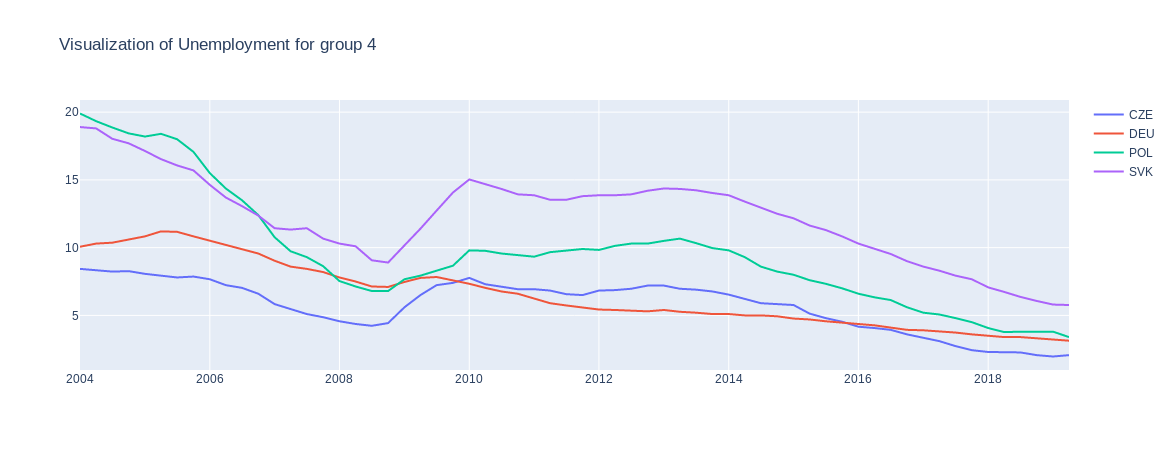

In [19]:
plotDifferentGroup(idx,df_hur,0,"Unemployment")
# plotDifferentGroup(idx,df_gdp,0,"Gdp growth")

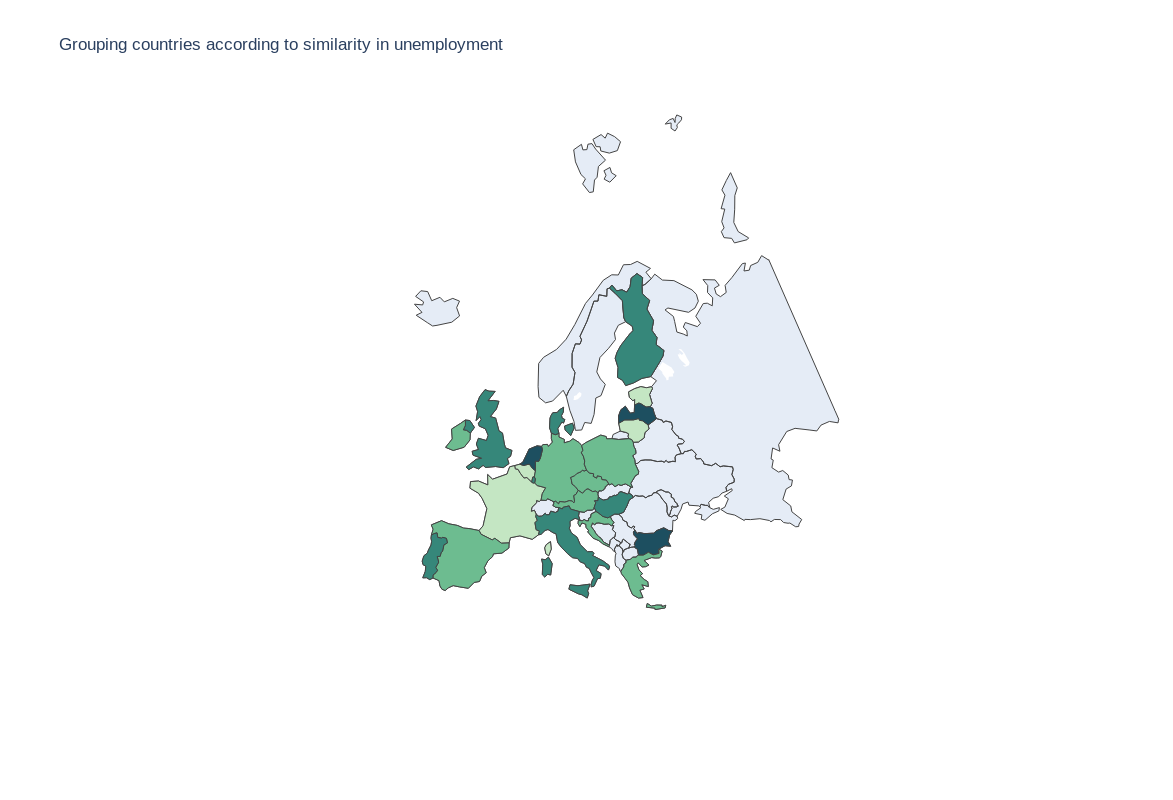

In [20]:
def plotMapStatic(idx, val):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list_iso, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        #colorscale=[            [0, "rgb(12,140,113)"],[0.5, "rgb(12,140,113)"],[0.5, "rgb(26,188,156)"],[1, "rgb(26,188,156)"]],
        colorscale="Blugrn",
        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = 'Grouping countries according to similarity in {}'.format(val),
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
        dragmode = False,
    )
    fig.show()

idx2=idx.copy()  
plotMapStatic(idx2,'unemployment')
# plotMapStatic(idx2,'GDP growth')

### yearly household information

In [105]:
#https://data.oecd.org/hha/household-disposable-income.htm#indicator-chart
df = generate_df(names_h,PATH_H)

In [106]:
df = df_date_format_yearly(df)

In [131]:
df

LOCATION        TIME  House_savings  House_net_worth  House_assets_total  \
6        AUT  2004-01-01       9.524268         372.5240        54178.240023   
7        AUT  2005-01-01      11.136395         370.2430        58896.636874   
8        AUT  2006-01-01      11.619636         376.9075        64013.453237   
9        AUT  2007-01-01      12.412376         381.3690        66647.596548   
10       AUT  2008-01-01      12.354529         369.0465        66574.832760   
..       ...         ...            ...              ...                 ...   
583      ROU  2014-01-01            NaN              NaN                 NaN   
584      ROU  2015-01-01            NaN              NaN                 NaN   
585      ROU  2016-01-01            NaN              NaN                 NaN   
586      ROU  2017-01-01            NaN              NaN                 NaN   
587      ROU  2018-01-01            NaN              NaN                 NaN   

     House_spending_total  House_Disp_inc_growth  House_disp_inc_gross  \
6             143563.4304               1.755185          26084.674549   
7             149903.8941               3.828940          27119.235749   
8             160076.7664               2.821967          28462.375034   
9             164146.6024               2.377307          29393.733451   
10            171924.4594               1.245440          30476.297121   
..                    ...                    ...                   ...   
583           249166.5359                    NaN                   NaN   
584           260240.5297                    NaN                   NaN   
585           290014.2373                    NaN                   NaN   
586           324520.8318                    NaN                   NaN   
587           338836.4352                    NaN                   NaN   

     House_spending_growth  House_debt  
6                 2.320888    81.19778  
7                 2.248423    87.18607  
8                 2.092393    88.55872  
9                 1.103724    88.36625  
10                0.946319    89.79839  
..                     ...         ...  
583                    NaN         NaN  
584                    NaN         NaN  
585                    NaN         NaN  
586                    NaN         NaN  
587                    NaN         NaN  

[420 rows x 10 columns]

# ICI TINMAR

In [ ]:
#split europe:

In [175]:
df2 = pd.read_csv('PIB28.csv')
df2['LOCATION'].unique().size

29

In [176]:
#select column name
column = "Value"
df_debt = df2[["LOCATION","TIME",column]].pivot_table(values=column, index='TIME', columns ='LOCATION')#values=column, index='TIME', columns='LOCATION')

In [177]:
#df_debt['LOCATIONS'].unique()#[df_debt['LOCATION']=='ESP']

In [178]:
from sklearn.cluster import KMeans

In [179]:
def plotMapStatic(idx, country_list, title):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        #colorscale=[            [0, "rgb(12,140,113)"],[0.5, "rgb(12,140,113)"],[0.5, "rgb(26,188,156)"],[1, "rgb(26,188,156)"]],
        colorscale="Blugrn",
        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
        dragmode = False,
    )
    fig.show()

def plot_k_mean_temporal_data(df, title, n_clusters=3):
    country_list = df.columns.values
    k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(df.transpose().values)
    groups = k_means.predict(df.transpose().values)
    #print(groups)
    #print(len(groups))
    #print(len(country_list))
    plotMapStatic(groups, country_list, title)
    return groups

In [180]:
df_debt.columns.values#.size

array(['AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST',
       'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU',
       'LUX', 'LVA', 'MLT', 'NLD', 'OECD', 'POL', 'PRT', 'ROU', 'SVK',
       'SVN', 'SWE'], dtype=object)

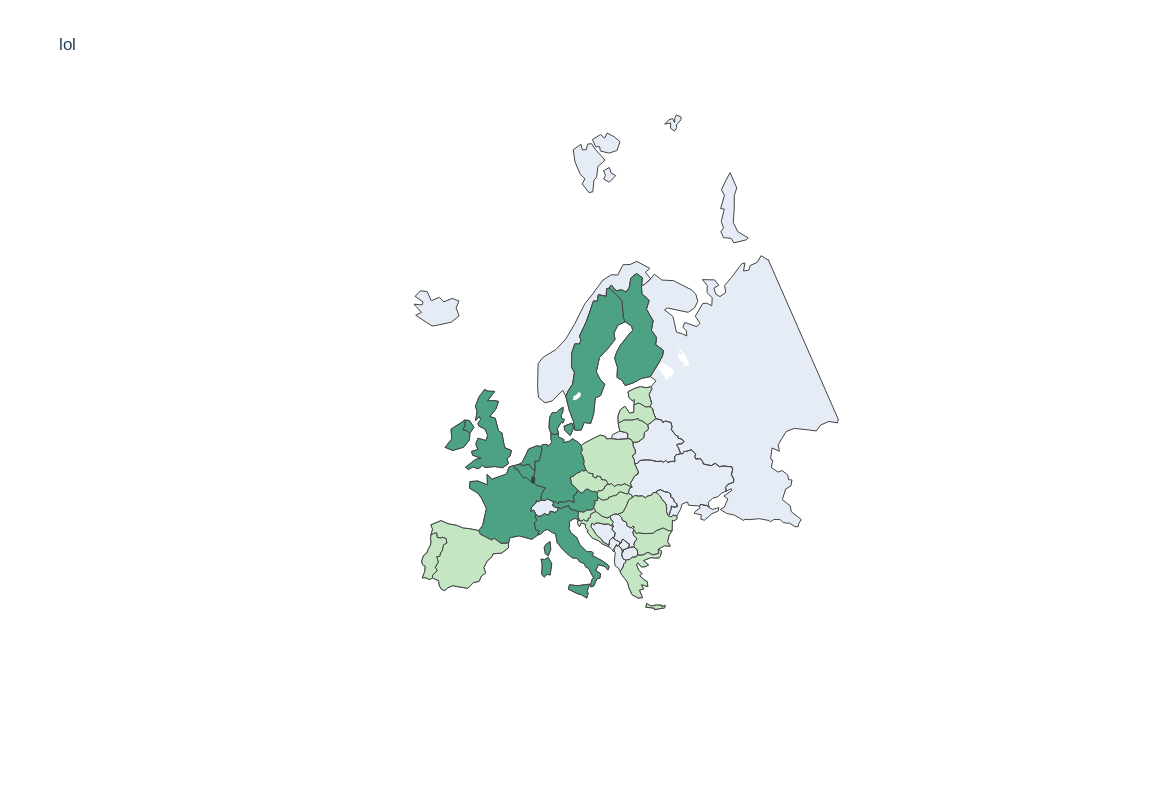

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1], dtype=int32)

In [182]:
plot_k_mean_temporal_data(df_debt, 'lol',3)

In [ ]:
#select column name
column = "House_net_worth"
df_debt = df[["LOCATION","TIME",column]].pivot_table(values=column, index='TIME', columns='LOCATION')

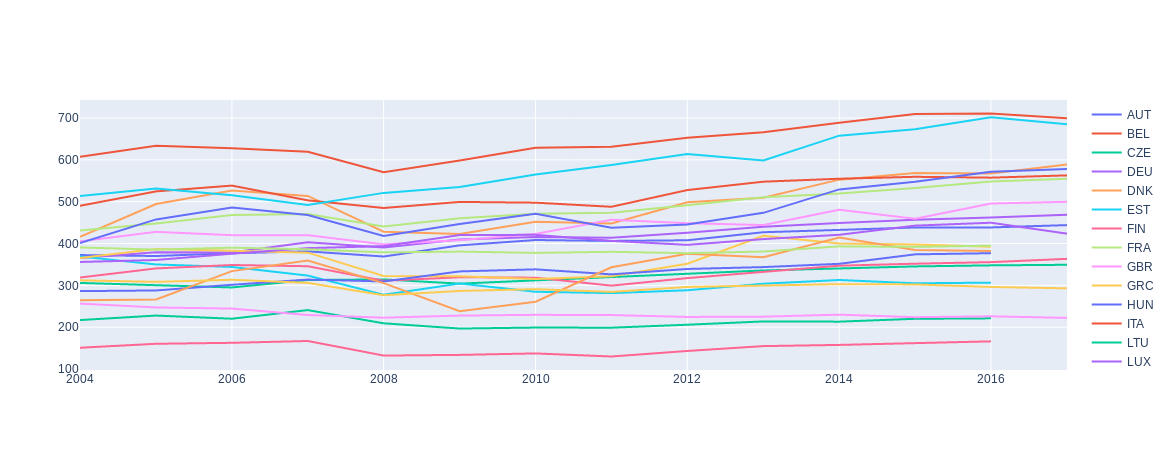

In [27]:
plot_lines(df_debt,0).show()

In [28]:
df_corr_debt = df_debt.corr(method ='spearman')

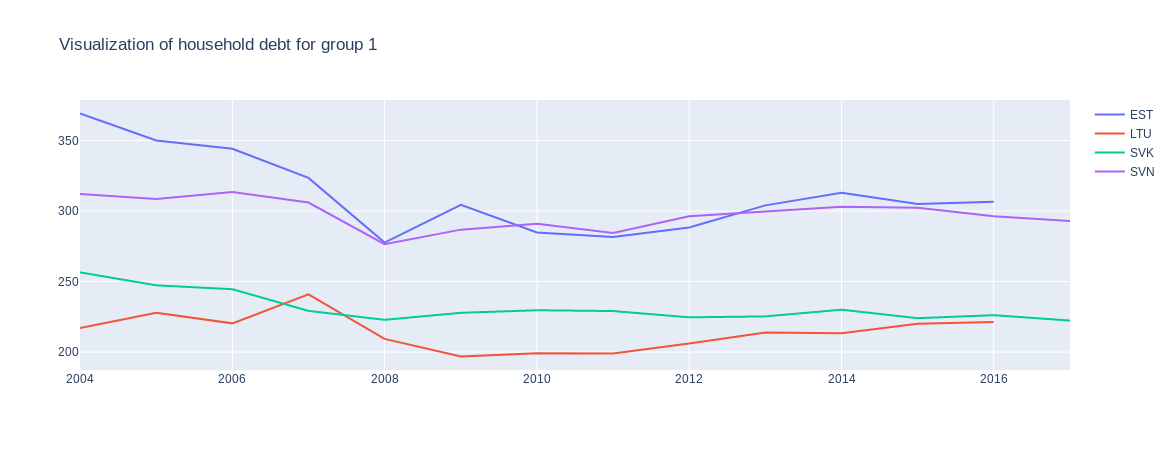

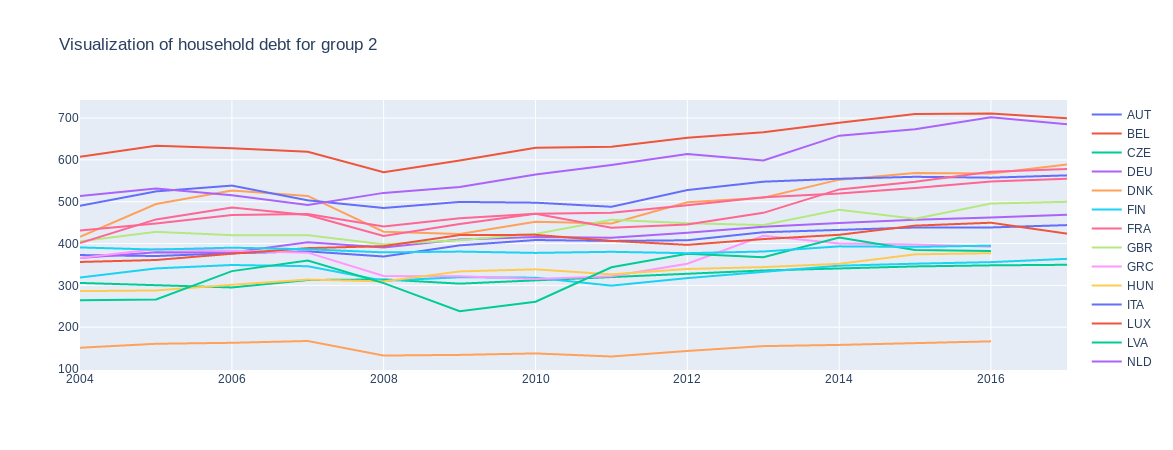

In [32]:
df_corr_debt = df_debt.corr(method ='spearman')
idx = getIdx(df_corr_debt,0.8)
plotDifferentGroup(idx,df_debt,0,'household debt')

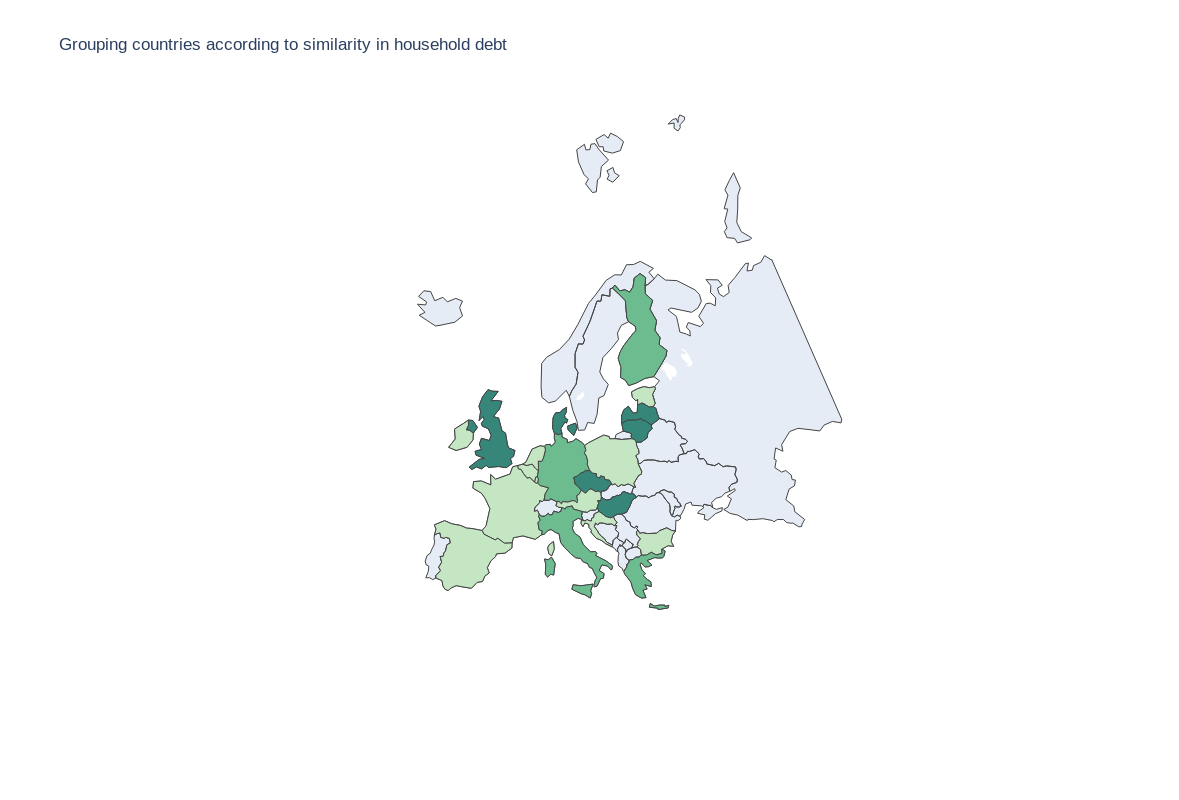

In [26]:
idx2=idx.copy()  
plotMapStatic(idx2,'household debt')